<a href="https://colab.research.google.com/github/aniruddh-joshi/Web-Development/blob/main/Age_Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 328M/331M [00:09<00:00, 42.2MB/s]
100% 331M/331M [00:09<00:00, 36.5MB/s]


In [10]:
#Required Libraries

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [12]:
#Data Gathering

In [13]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [14]:
BASE_DIR = '/content/UTKFace'

In [15]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [16]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/28_1_1_20170116235605486.jpg....,28,1
1,/content/UTKFace/3_1_2_20161220220305826.jpg.c...,3,1
2,/content/UTKFace/29_0_1_20170117022120994.jpg....,29,0
3,/content/UTKFace/30_0_0_20170104000150443.jpg....,30,0
4,/content/UTKFace/25_0_1_20170113145422493.jpg....,25,0


In [17]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [18]:
#Exploratory Data Analysis

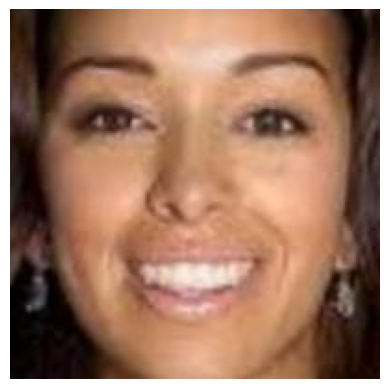

In [19]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

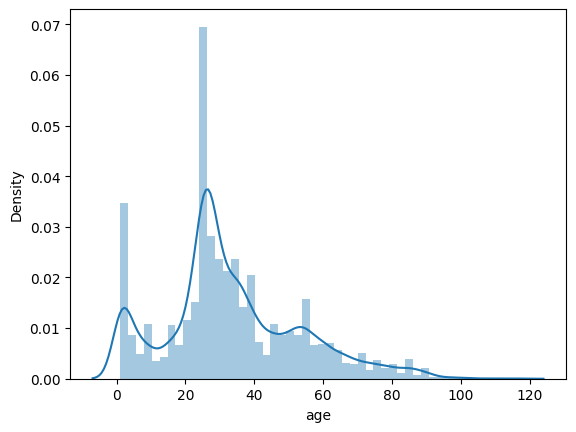

In [20]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

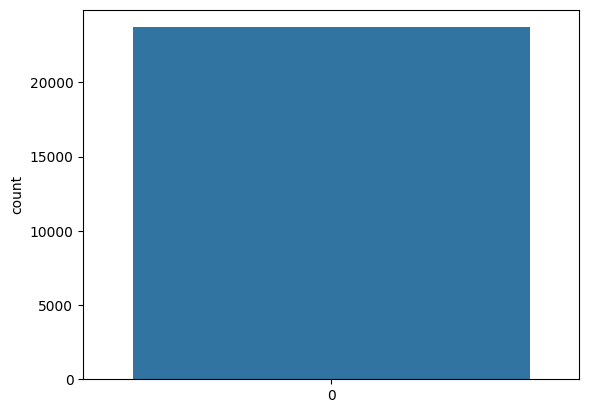

In [21]:
sns.countplot(df['gender'])

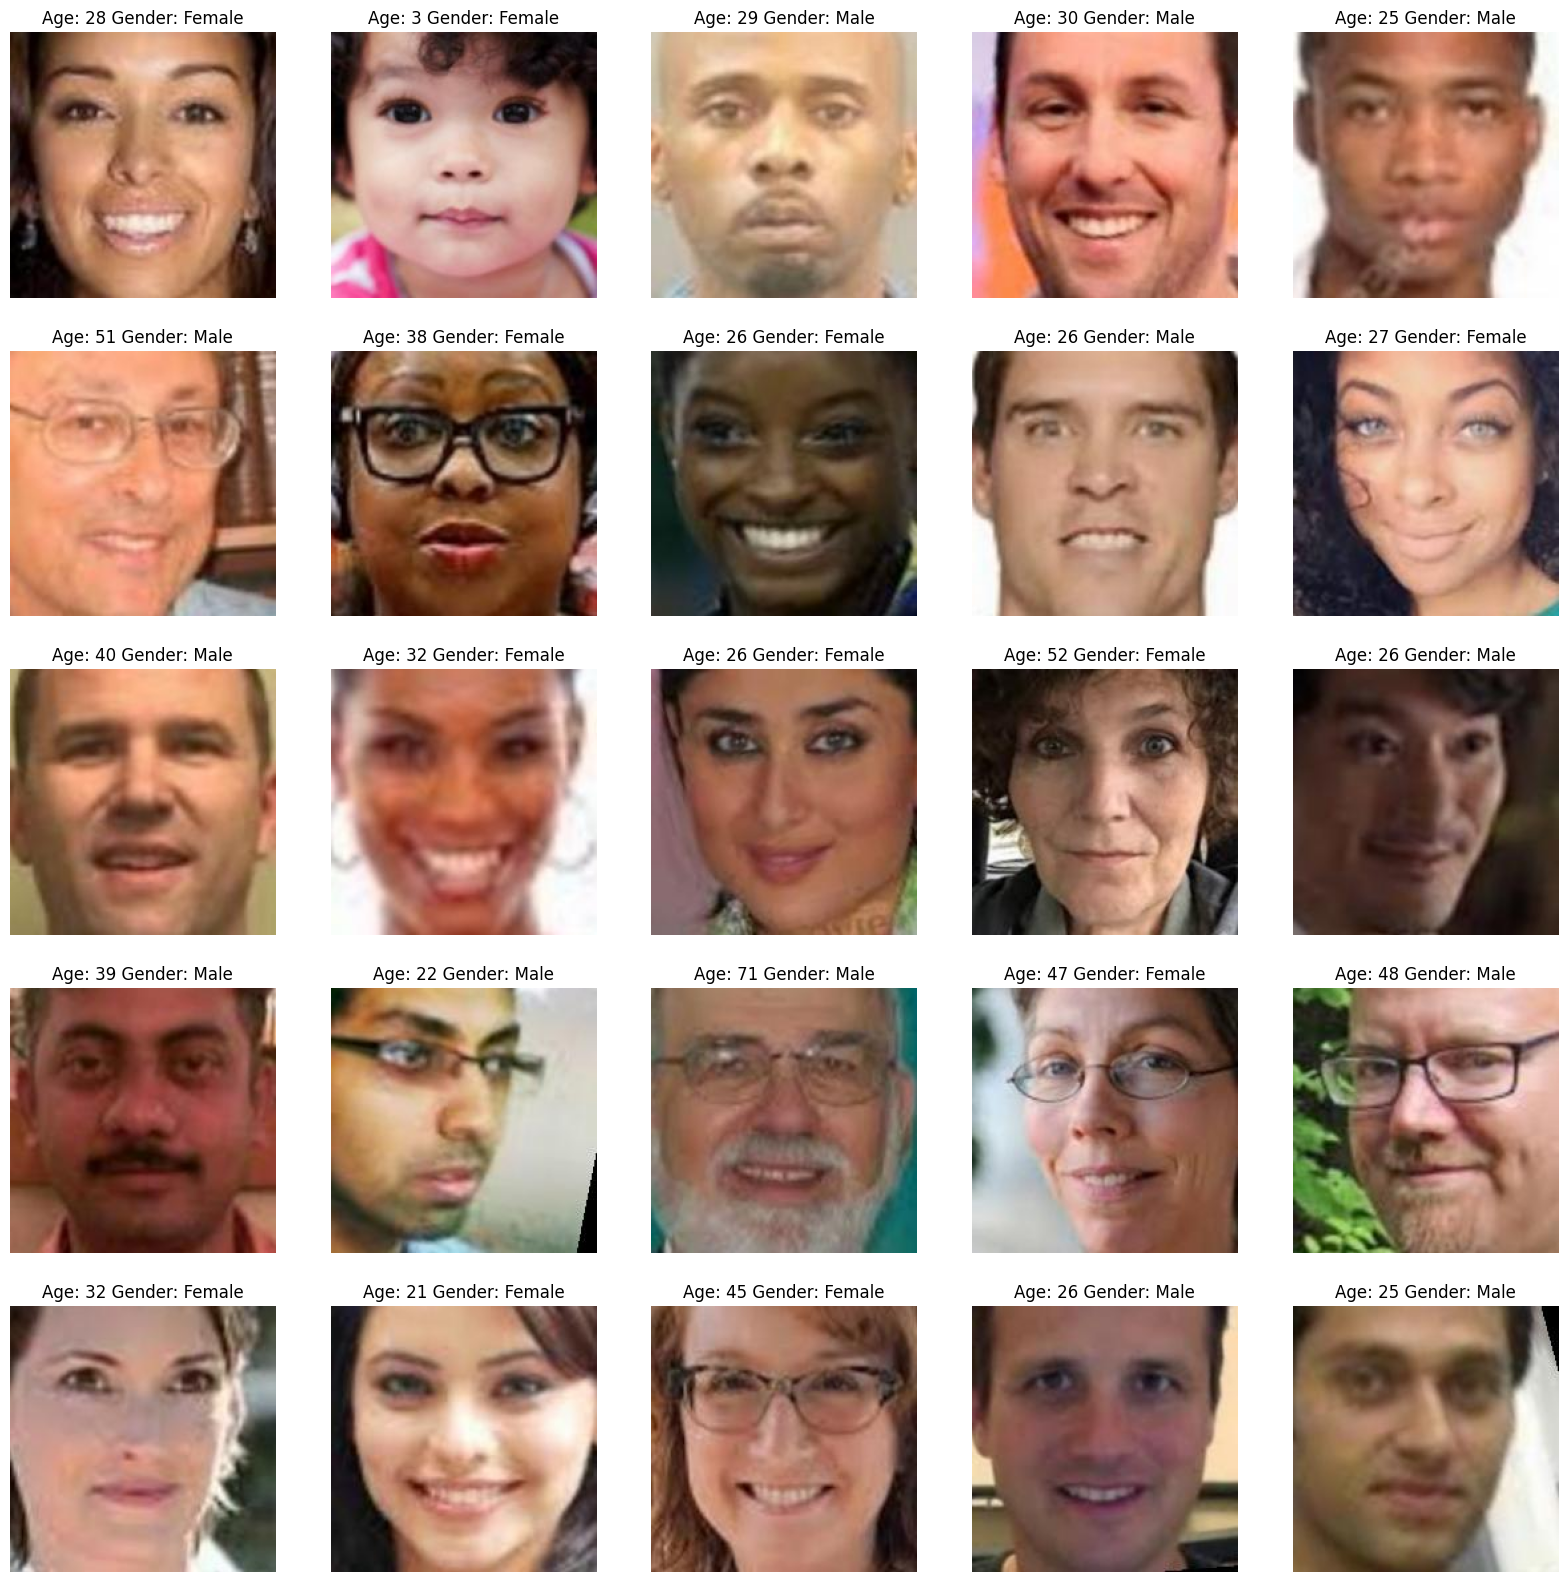

In [22]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [23]:
#Feature Extraction

In [24]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [25]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [26]:
X.shape

(23708, 128, 128, 1)

In [27]:
# normalize the images
X = X/255.0

In [28]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [29]:
input_shape = (128, 128, 1)

In [30]:
#Model Creation

In [31]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

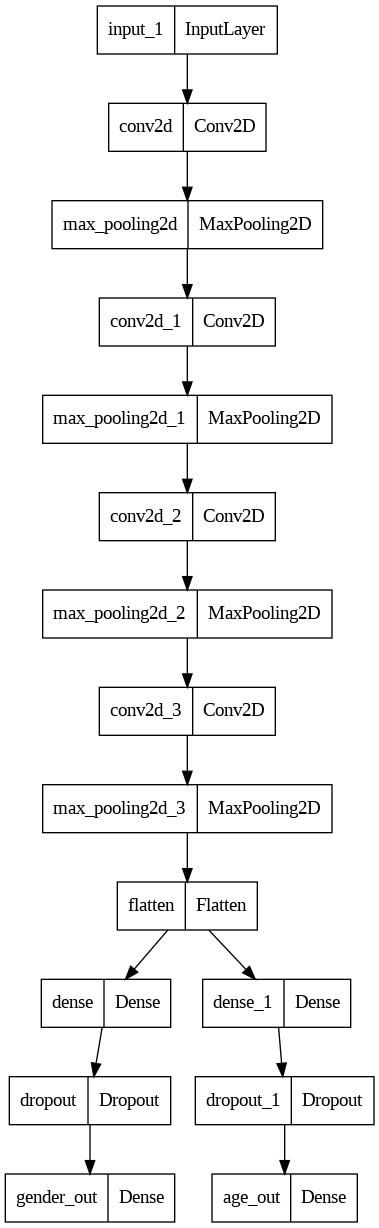

In [32]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [33]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 29s 24ms/step - loss: 15.5986 - gender_out_loss: 0.6692 - age_out_loss: 14.9294 - gender_out_accuracy: 0.5768 - age_out_accuracy: 0.0478 - val_loss: 11.6265 - val_gender_out_loss: 0.5225 - val_age_out_loss: 11.1040 - val_gender_out_accuracy: 0.7412 - val_age_out_accuracy: 0.0342
Epoch 2/30
593/593 [==============================] - 12s 20ms/step - loss: 11.3677 - gender_out_loss: 0.4748 - age_out_loss: 10.8928 - gender_out_accuracy: 0.7726 - age_out_accuracy: 0.0257 - val_loss: 9.7718 - val_gender_out_loss: 0.4295 - val_age_out_loss: 9.3423 - val_gender_out_accuracy: 0.7990 - val_age_out_accuracy: 0.0116
Epoch 3/30
593/593 [==============================] - 12s 20ms/step - loss: 9.8868 - gender_out_loss: 0.4067 - age_out_loss: 9.4802 - gender_out_accuracy: 0.8088 - age_out_accuracy: 0.0138 - val_loss: 9.0403 - val_gender_out_loss: 0.3650 - val_age_out_loss: 8.6753 - val_gender_out_accuracy: 0.8399 - val_age_out_accuracy: 0.0076
Epoc

In [34]:
#Plot the Results

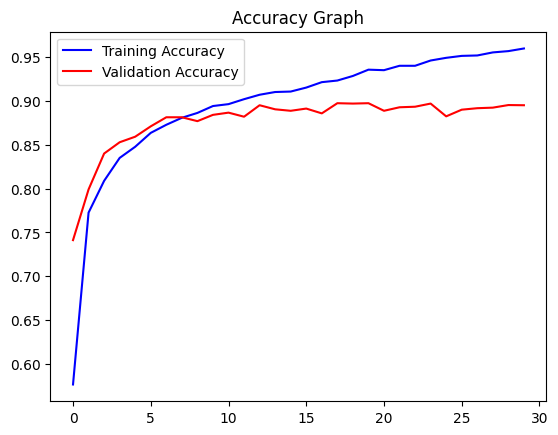

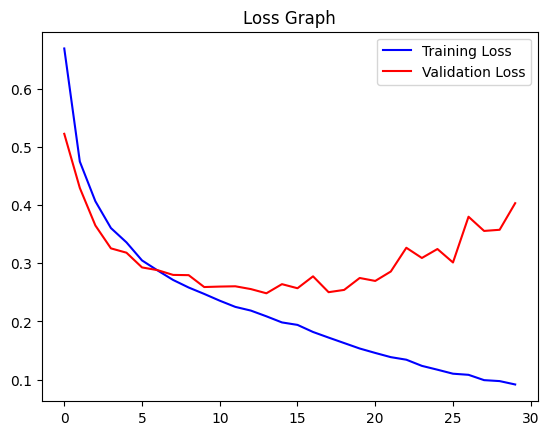

In [35]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

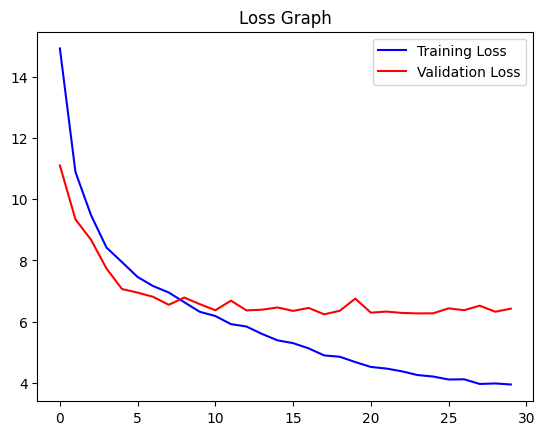

In [36]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [37]:
#Prediction with Test Data

Original Gender: Female Original Age: 68
1/1 [==============================] - 0s 235ms/step
Predicted Gender: Female Predicted Age: 62


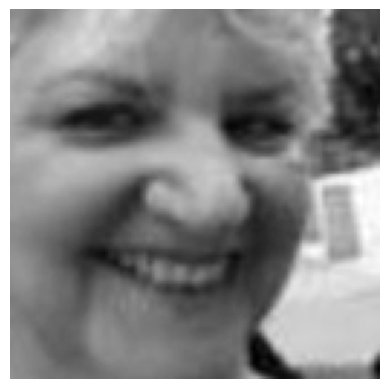

In [38]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 22
1/1 [==============================] - 0s 18ms/step
Predicted Gender: Female Predicted Age: 26


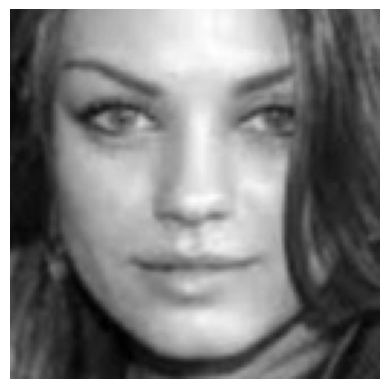

In [39]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 19
1/1 [==============================] - 0s 26ms/step
Predicted Gender: Male Predicted Age: 24


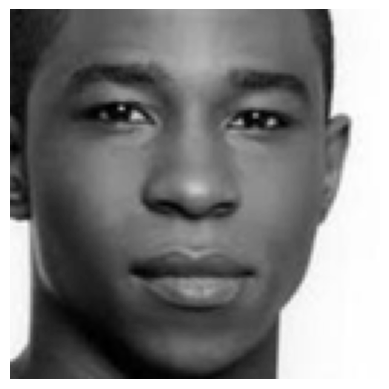

In [40]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 46
1/1 [==============================] - 0s 17ms/step
Predicted Gender: Male Predicted Age: 44


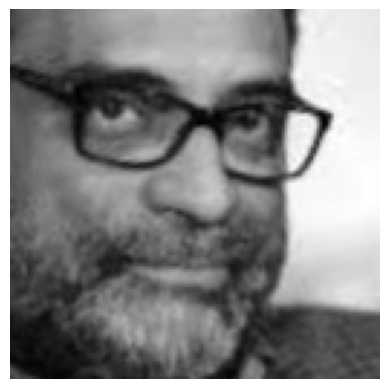

In [41]:
image_index = 1050
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

1/1 [==============================] - 0s 17ms/step
Predicted Gender: Male Predicted Age: 44


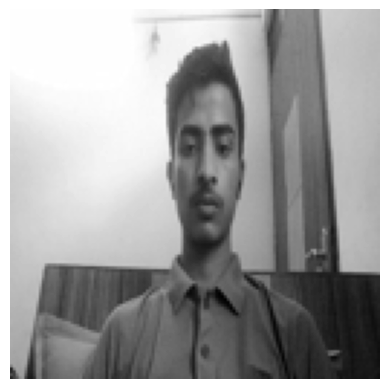

In [43]:
from PIL import Image

# Load the image
image_path = '/content/ajtitan.jpg'
image = Image.open(image_path)

# Preprocess the image (resize, convert to grayscale, etc.)
# You need to adjust this based on your model's input requirements
# For example, if your model expects 128x128 grayscale images:
image = image.resize((128, 128)).convert('L')
image_array = np.array(image)  # Assuming you're using numpy

# Reshape the image array to match the model input shape
image_array = image_array.reshape((1, 128, 128, 1))

# Predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(image_array.reshape(128, 128), cmap='gray');


1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: 44


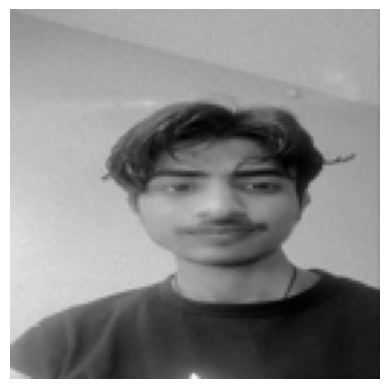

In [44]:
from PIL import Image

# Load the image
image_path = '/content/ashish.jpg'
image = Image.open(image_path)

# Preprocess the image (resize, convert to grayscale, etc.)
# You need to adjust this based on your model's input requirements
# For example, if your model expects 128x128 grayscale images:
image = image.resize((128, 128)).convert('L')
image_array = np.array(image)  # Assuming you're using numpy

# Reshape the image array to match the model input shape
image_array = image_array.reshape((1, 128, 128, 1))

# Predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(image_array.reshape(128, 128), cmap='gray');
